In [4]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

## 1. EDA

In [5]:

with open(r'Data/churn_model_pd2.pcl', 'rb') as f:
    bdl_data = pickle.load(f)
gen_info, train_data, test_data = bdl_data
train_info, df_train_fe, df_train_bnum, df_train_dpi = train_data
test_info, df_test_fe, df_test_bnum, df_test_dpi = test_data


In [6]:
# show holes after removing empty

def drop_columns_with_nulls(frame: pd.DataFrame, threshold: float = 0.7) -> pd.DataFrame:
    """
    Drop columns with more than threshold % of nulls
    """
    return frame.dropna(thresh=threshold*frame.shape[0], axis=1)

In [7]:
df_train_fe_df = pd.DataFrame(df_train_fe)
df_train_bnum_df = pd.DataFrame(df_train_bnum)
df_train_dpi_df = pd.DataFrame(df_train_dpi)

df_train_dpi_df_clean = drop_columns_with_nulls(df_train_fe_df)

In [9]:
# load features.json
import json
with open(r'Data/features.json', 'r') as f:
    features = json.load(f)

with open(r'Data/features_scaled.json', 'r') as f:
    features_scaled = json.load(f)

In [5]:
len(features_scaled['lgbm_features'])

526

In [38]:
len(features['best_features'])

110

In [5]:
# sort by sum descending

df_train_fe_df.isnull().sum().sort_values(ascending=False)

bs_of_recall_m1                     150000
bs_of_succ_m1                       150000
bs_of_succ_but_drop_m1              150000
bs_of_unsucc_attemp_equip_m1        150000
bs_recall_rate                      150000
                                     ...  
voice_mts_in_nrest_part_td_mnt3          0
voice_out_cmpttrs_td_cntstd_mnt1         0
accum_oth_dur_mea_mnt3                   0
voice_mts_out_dwork_partmin_mnt1         0
abon_id                                  0
Length: 817, dtype: int64

In [42]:
# convert df_train_fe to a dataframe

nulls = df_train_fe_df.isnull().sum()
nulls = nulls[nulls > len(df_train_fe_df) * 0.5]
len(nulls)



63

In [6]:
# missing data
df_train_fe_df.isnull().sum()

Ama_rchrgmnt_sum_max_mnt1                0
content_clc_mea_mnt1                     0
content_cnt_max_mnt1                     0
voice_out_short_part_max_mnt1            0
voice_mts_in_nrest_part_std_mnt1         0
                                     ...  
MV_DOU_PPM_VF                        72366
MV_DOU_Neg_Bal                      149887
MV_ot_total                          41450
target                                   0
abon_id                                  0
Length: 817, dtype: int64

In [7]:
df_train_fe_df.duplicated().sum()

0

In [8]:
corr = df_train_fe_df.sample(frac=0.2, random_state=42).reset_index(drop=True).corr()


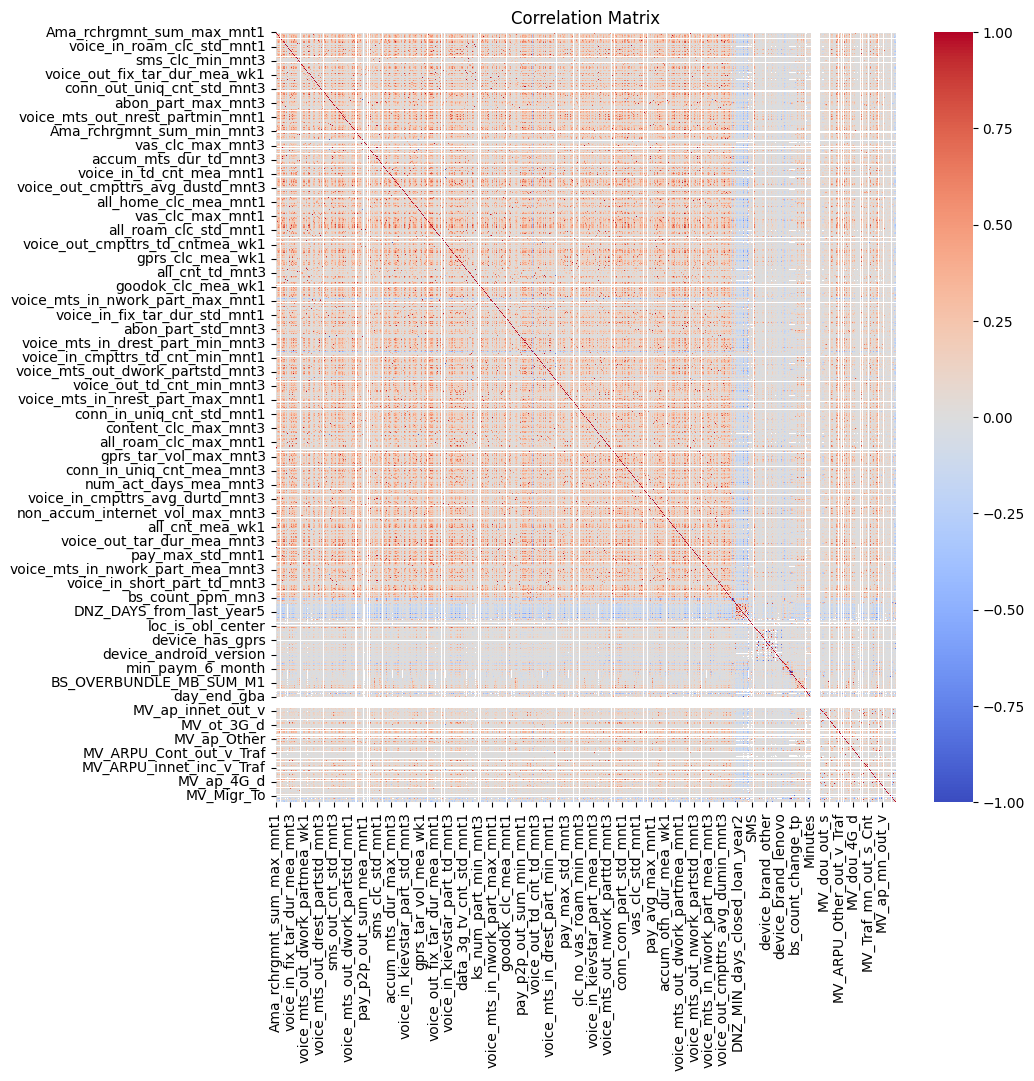

In [9]:
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [11]:
# count how many times each ds is present in ds
pd.value_counts(df_train_fe_df.dtypes)

/var/folders/gb/2pnwp8l93877rycd4yv9lxd80000gn/T/ipykernel_70388/1520910339.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(df_train_fe_df.dtypes)


float64    784
int64       32
int32        1
Name: count, dtype: int64

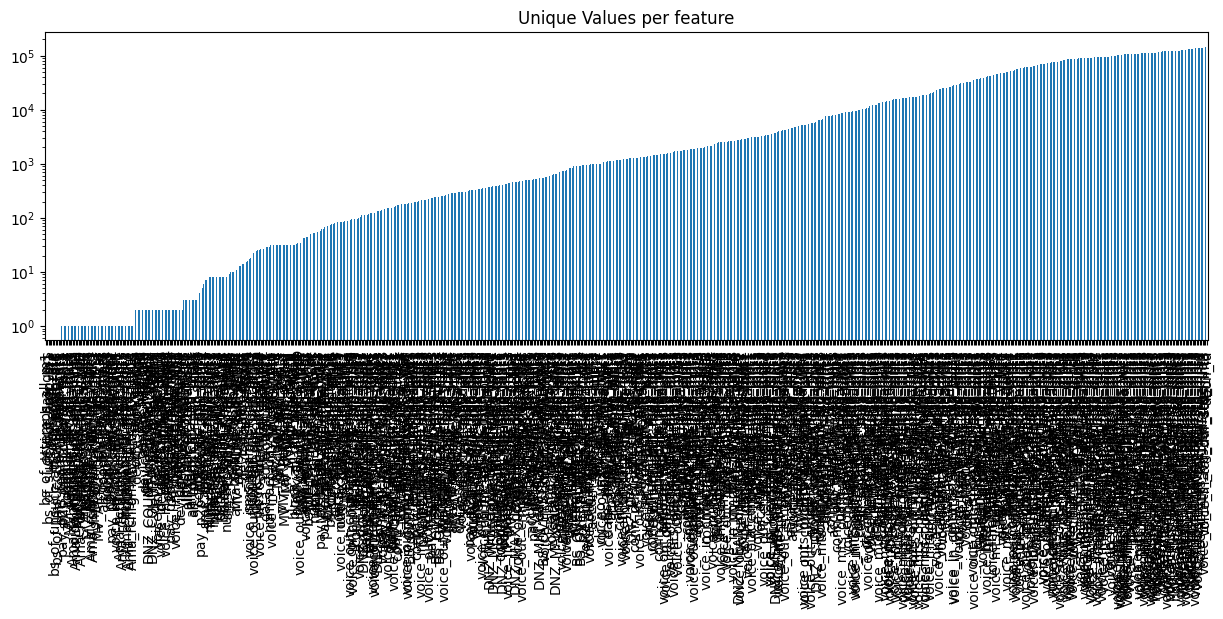

In [14]:
# let's take a closer look onn numerical features
# for each feature compute number of unique values
def plot_unique_values(df: pd.DataFrame) -> None:
    unique_values = df.select_dtypes(include='number').nunique().sort_values()
    unique_values.plot.bar(logy=True, figsize=(15,4), title='Unique Values per feature')

plot_unique_values(df_train_fe_df)

In [19]:
# let's estimate amount of records with missing data
def show_holes_simple(df: pd.DataFrame) -> None:
    plt.figure(figsize=(10, 10))
    plt.imshow(df, aspect='auto', interpolation='nearest', cmap='grey')
    plt.xlabel('Column Number')
    plt.ylabel('Sample Number')

Text(0, 0.5, 'Sample Number')

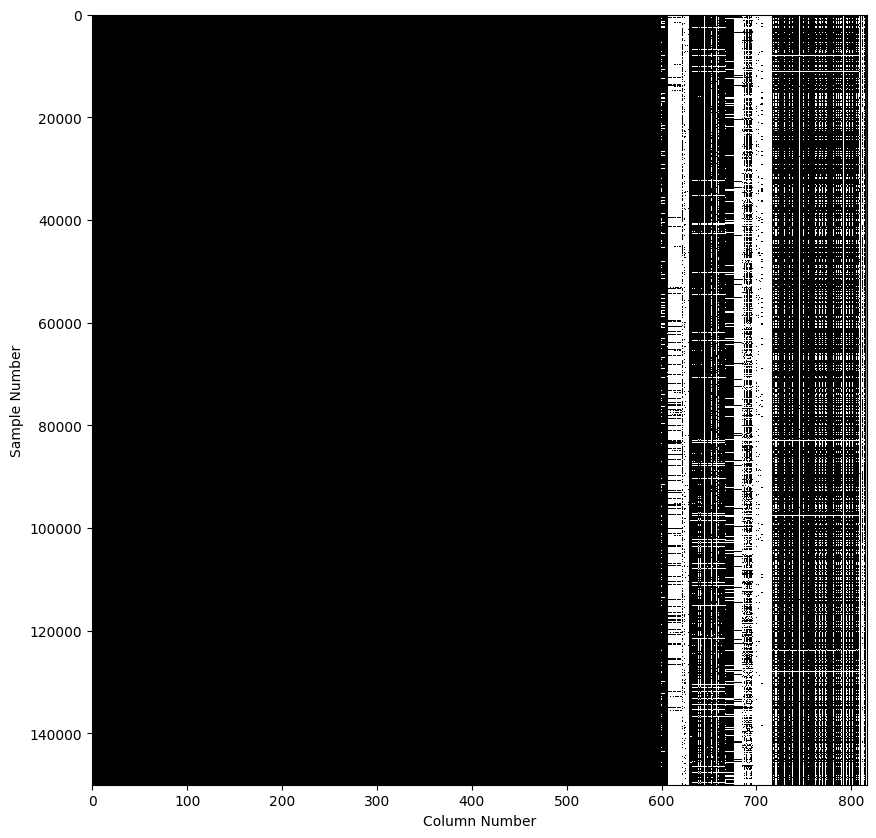

In [18]:
show_holes_simple(df_train_fe_df)



In [6]:


# show_holes_simple(drop_columns_with_nulls(df_train_fe_df))

In [23]:
# import missingno as msno

# msno.matrix(df_train_fe_df, labels=True, sort="descending");

In [29]:
missing_per_feature = df_train_fe_df.isna().mean().sort_values()
# 0 if no missings
# 1 if all missings
missing_per_feature[missing_per_feature > 0].shape

(212,)

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
          ..
149995   NaN
149996   NaN
149997   NaN
149998   NaN
149999   NaN
Name: bs_succ_rate, Length: 150000, dtype: float64

In [32]:
# let's estimate ratio of missing values per feature
def missing_per_feature(df: pd.DataFrame, threshold=0) -> None:
    missing_per_feature = df.isna().mean()
    # 0 if no missings
    # 1 if all missings
    missing_per_feature[missing_per_feature > threshold].sort_values().plot(
        kind='bar', figsize=(17,4),
        title='Percentage of missing values per feature',
        ylabel ='Ratio of missing values per feature'
    )

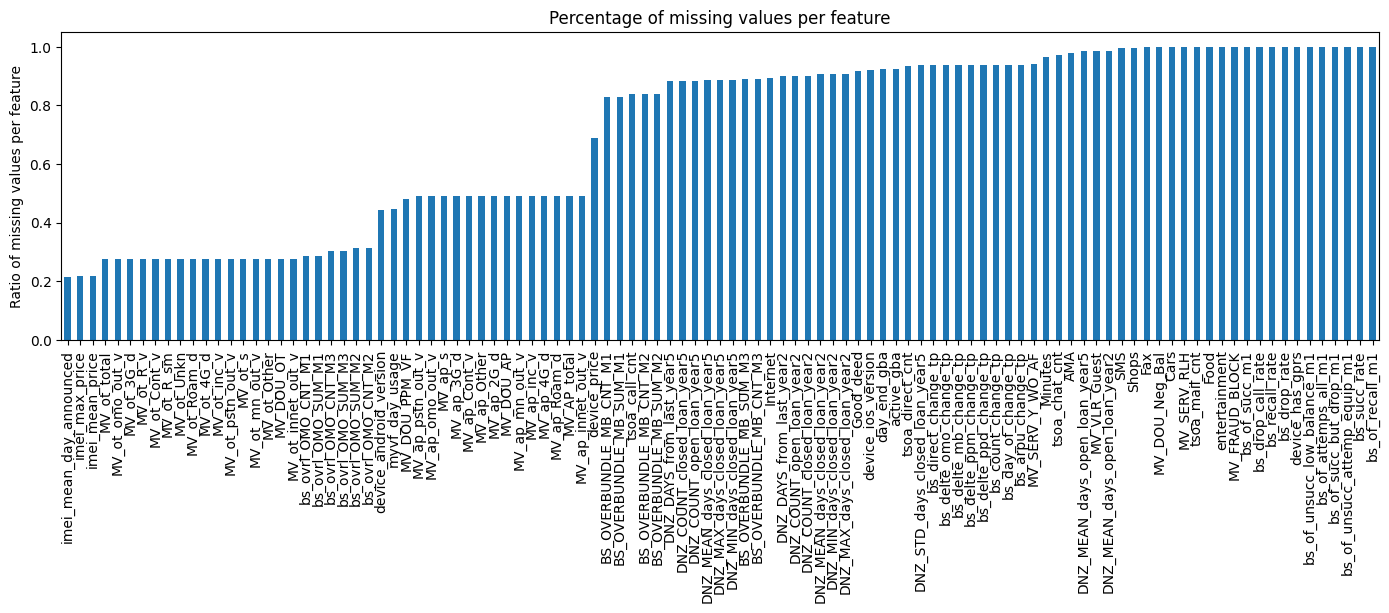

In [33]:
missing_per_feature(df_train_fe_df, threshold=0.2)

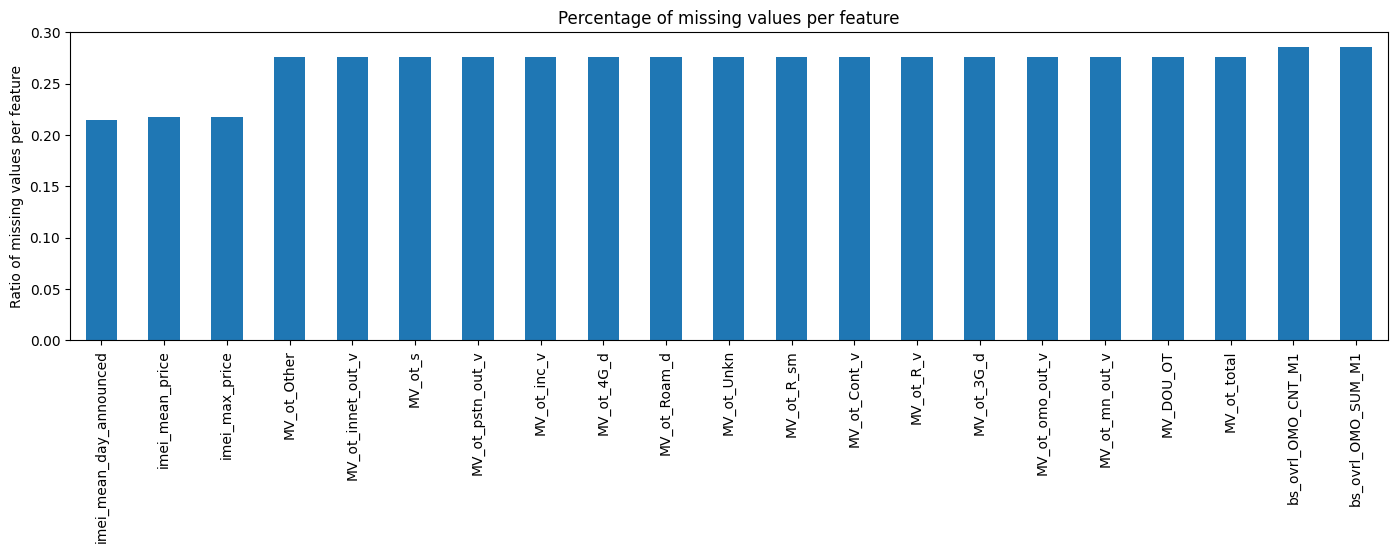

In [34]:
missing_per_feature(drop_columns_with_nulls(df_train_fe_df), threshold=0.2)


In [36]:
df_train_dpi_df_clean.shape

(150000, 733)

In [61]:
# we will compare 2 datasets features and features_scale
missing  = set(features_scaled['lgbm_features']) - set(df_train_dpi_df_clean.columns)
lgbm_features_clean = [r for r in features_scaled['lgbm_features'] if r not in missing]


In [62]:
len(lgbm_features_clean)

516

array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <A

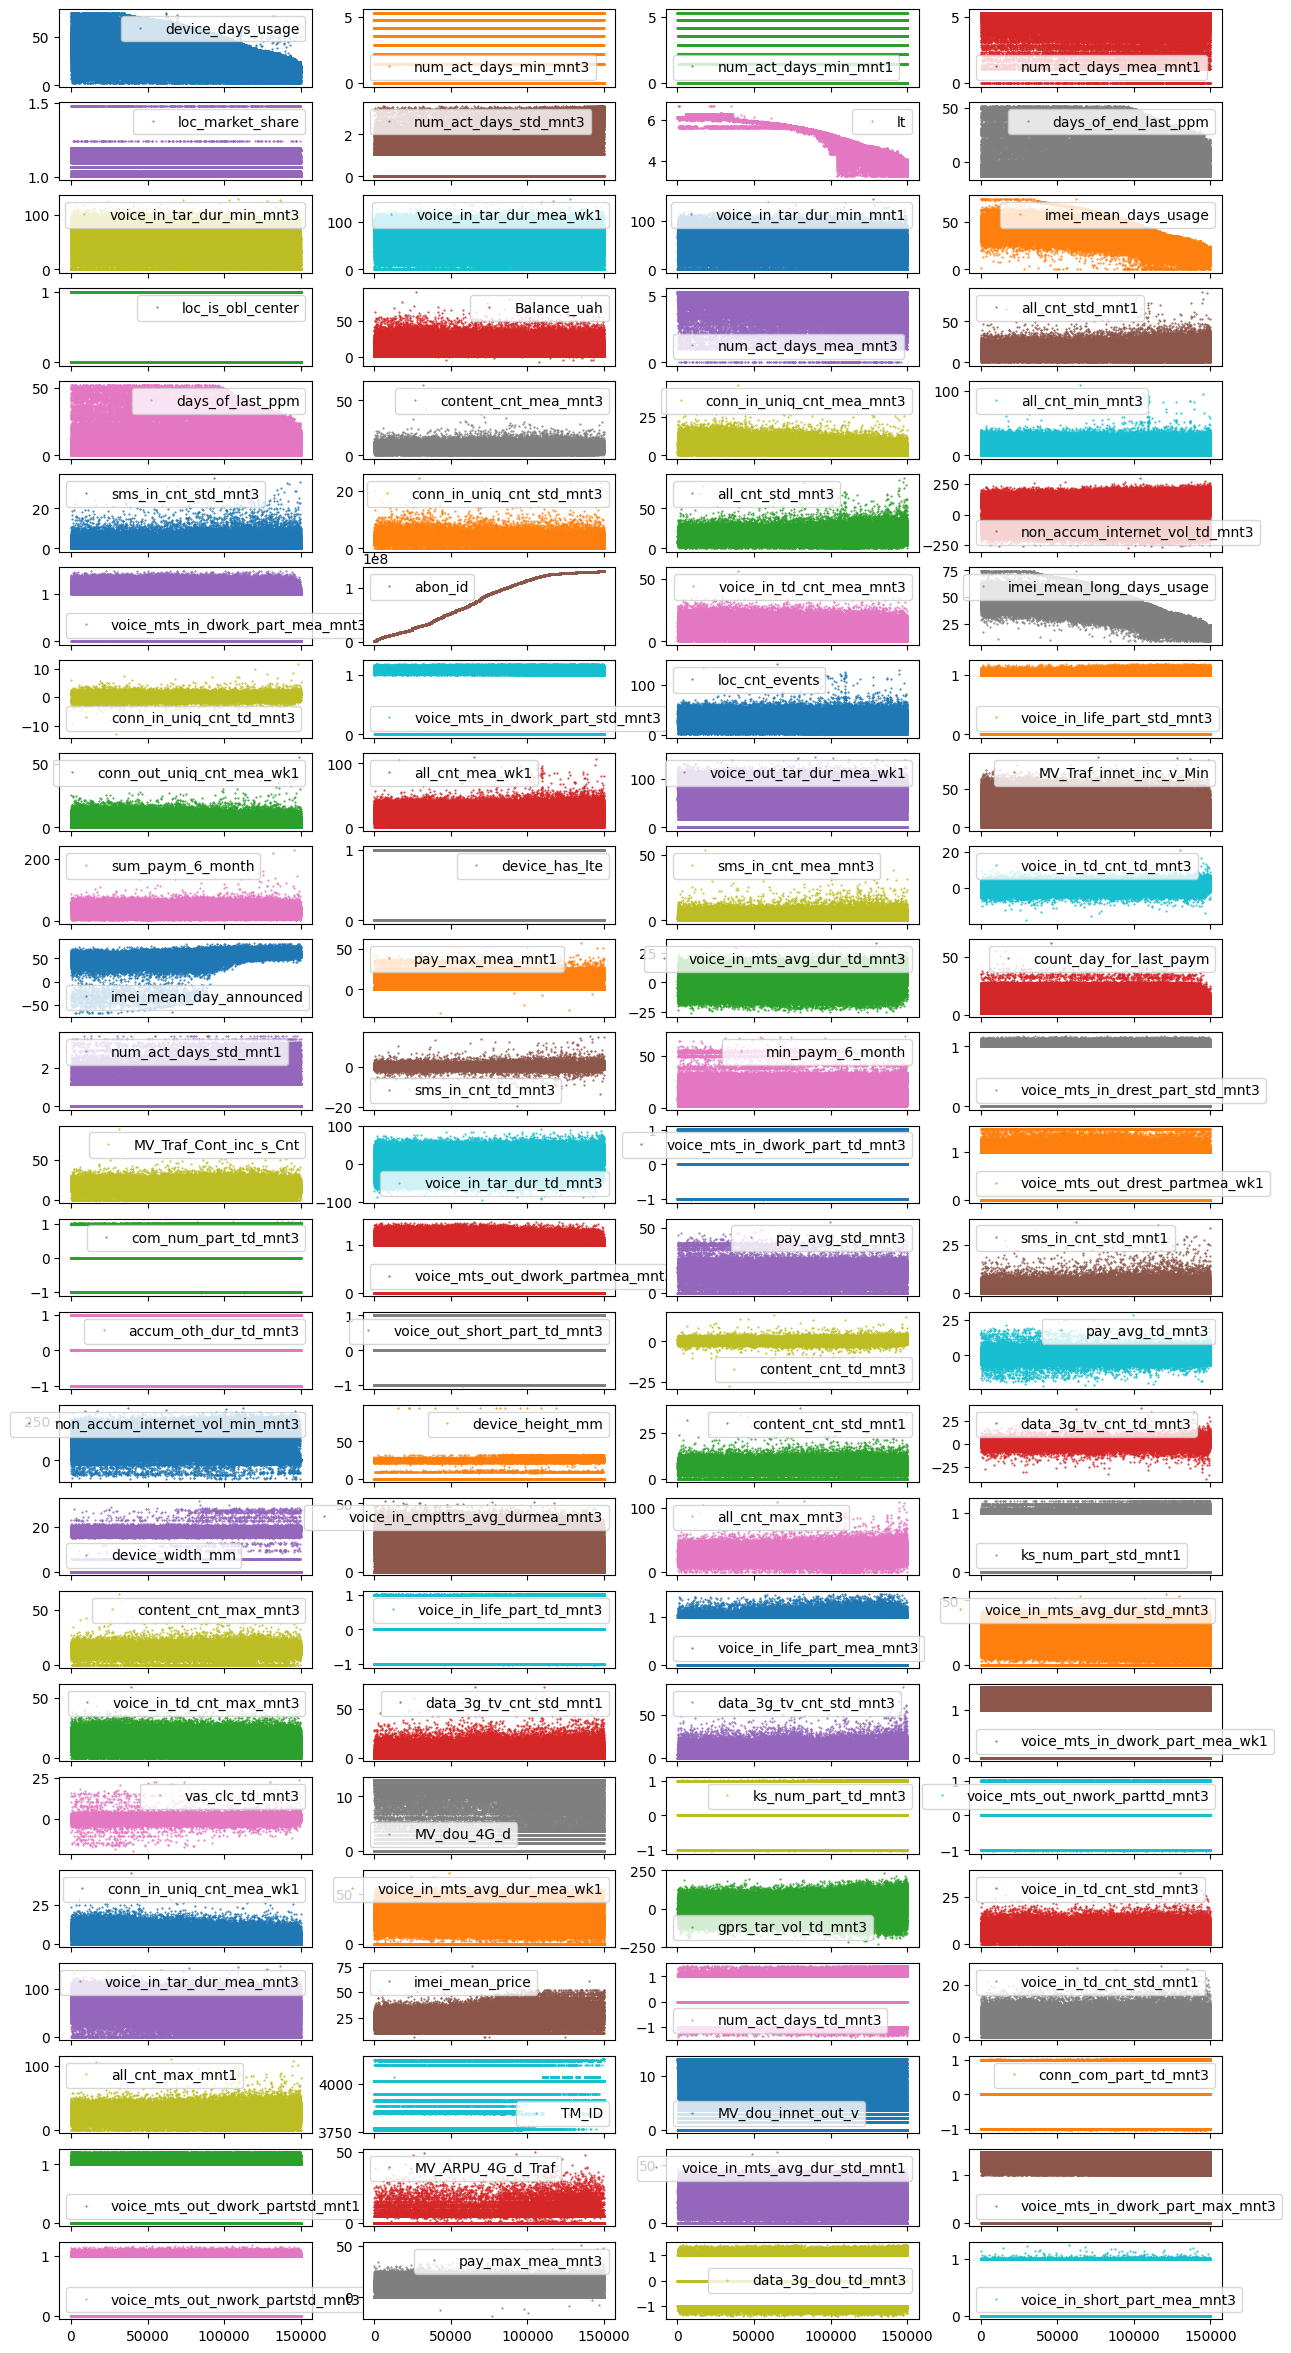

In [64]:


df_train_dpi_df_clean[lgbm_features_clean[:100]].plot(lw=0, marker='.', subplots=True, layout=(-1, 4), figsize=(15, 30), markersize=1)

NameError: name 'df_train_dpi_df_clean' is not defined

In [82]:
most_frequent_entry[:1]

Ama_rchrgmnt_sum_max_mnt1  content_clc_mea_mnt1  content_cnt_max_mnt1  \
0                        0.0                   0.0             10.269117   

   voice_out_short_part_max_mnt1  voice_mts_in_nrest_part_std_mnt1  \
0                            0.0                               0.0   

   num_act_days_max_mnt1  sms_roam_clc_min_mnt1  \
0               5.324077                    0.0   

   voice_in_cmpttrs_avg_durmin_mnt1  com_num_part_mea_mnt1  pay_avg_mea_mnt1  \
0                               0.0                    0.0               0.0   

   ...  MV_ARPU_R_inc_v_Traf  MV_ARPU_2G_d_Traf  MV_ot_Other  \
0  ...                   0.0                0.0          0.0   

   MV_Traf_ACCA_out_v_Min  MV_Traf_mn_out_v_Min  MV_DOU_OT  MV_Migr_To  \
0                     0.0                   0.0   1.480453         0.0   

   MV_ot_total  target  abon_id  
0          0.0     0.0  1545052  

[1 rows x 733 columns]

In [10]:
# for each entrry check if it contains most frequent 
# find most frequent entry
most_frequent_entry =  df_train_dpi_df_clean.drop(columns=['target', 'abon_id']).mode()
df_freq  = df_train_dpi_df_clean.eq(most_frequent_entry.iloc[0], axis=1)

In [11]:
# return mean() as Series
df_freq

Ama_rchrgmnt_sum_max_mnt1  Ama_rchrgmnt_sum_max_mnt3  \
0                            True                       True   
1                            True                       True   
2                            True                       True   
3                            True                       True   
4                            True                       True   
...                           ...                        ...   
149995                       True                       True   
149996                       True                       True   
149997                       True                       True   
149998                       True                       True   
149999                       True                       True   

        Ama_rchrgmnt_sum_mea_mnt1  Ama_rchrgmnt_sum_mea_mnt3  \
0                            True                       True   
1                            True                       True   
2                            True                       True   
3                            True                       True   
4                            True                       True   
...                           ...                        ...   
149995                       True                       True   
149996                       True                       True   
149997                       True                       True   
149998                       True                       True   
149999                       True                       True   

        Ama_rchrgmnt_sum_mea_wk1  Ama_rchrgmnt_sum_min_mnt1  \
0                           True                       True   
1                           True                       True   
2                           True                       True   
3                           True                       True   
4                           True                       True   
...                          ...                        ...   
149995                      True                       True   
149996                      True                       True   
149997                      True                       True   
149998                      True                       True   
149999                      True                       True   

        Ama_rchrgmnt_sum_min_mnt3  Ama_rchrgmnt_sum_std_mnt1  \
0                            True                       True   
1                            True                       True   
2                            True                       True   
3                            True                       True   
4                            True                       True   
...                           ...                        ...   
149995                       True                       True   
149996                       True                       True   
149997                       True                       True   
149998                       True                       True   
149999                       True                       True   

        Ama_rchrgmnt_sum_std_mnt3  Ama_rchrgmnt_sum_td_mnt3  ...  \
0                            True                      True  ...   
1                            True                      True  ...   
2                            True                      True  ...   
3                            True                      True  ...   
4                            True                      True  ...   
...                           ...                       ...  ...   
149995                       True                      True  ...   
149996                       True                      True  ...   
149997                       True                      True  ...   
149998                       True                      True  ...   
149999                       True                      True  ...   

        voice_out_td_cnt_max_mnt1  voice_out_td_cnt_max_mnt3  \
0                           False                      False   

NameError: name 'df_freq_' is not defined

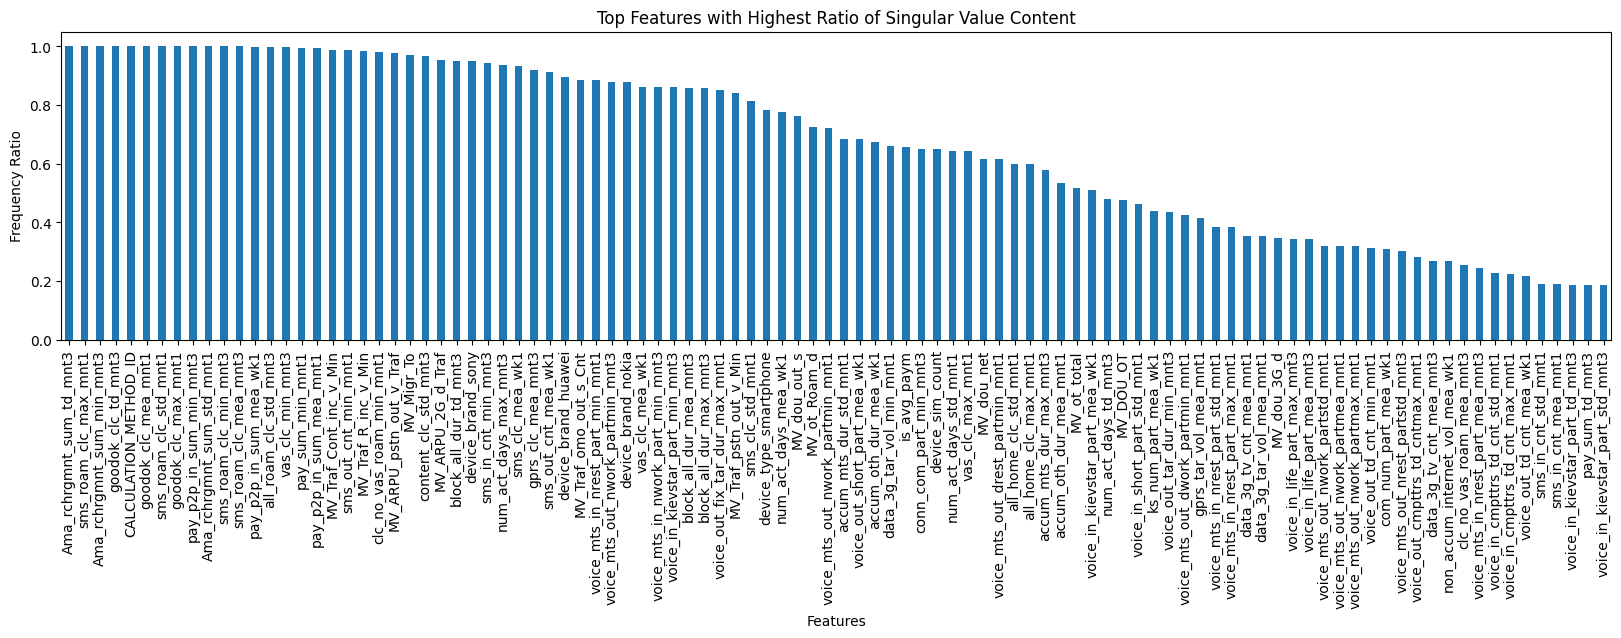

In [13]:
# compute the mean of the most frequent entries
df_freq_ = df_freq.mean()

df_freq_.sample(frac=0.2).sort_values(ascending=False).head(100).plot(kind='bar', figsize=(20, 4))
plt.title('Top Features with Highest Ratio of Singular Value Content')
plt.ylabel('Frequency Ratio')
plt.xlabel('Features')
plt.show()

# not very useful

In [28]:
# df_freq_[df_freq_ > 0.9]
def get_feature_with_high_singular_value_content(df: pd.DataFrame, threshold: float = 0.9, plot: bool = True) -> pd.Series:
    most_frequent_entry =  df.drop(columns=['target', 'abon_id']).mode()
    df_freq  = df.eq(most_frequent_entry.iloc[0], axis=1)
    df_freq_ = df_freq.mean()
    with_threshold = df_freq_[df_freq_ > threshold]
    if plot:
        with_threshold.sort_values(ascending=False).head(100).plot(kind='bar', figsize=(20, 4))
        plt.title('Top Features with Highest Ratio of Singular Value Content')
        plt.ylabel('Frequency Ratio')
        plt.xlabel('Features')
        plt.show()
    return with_threshold



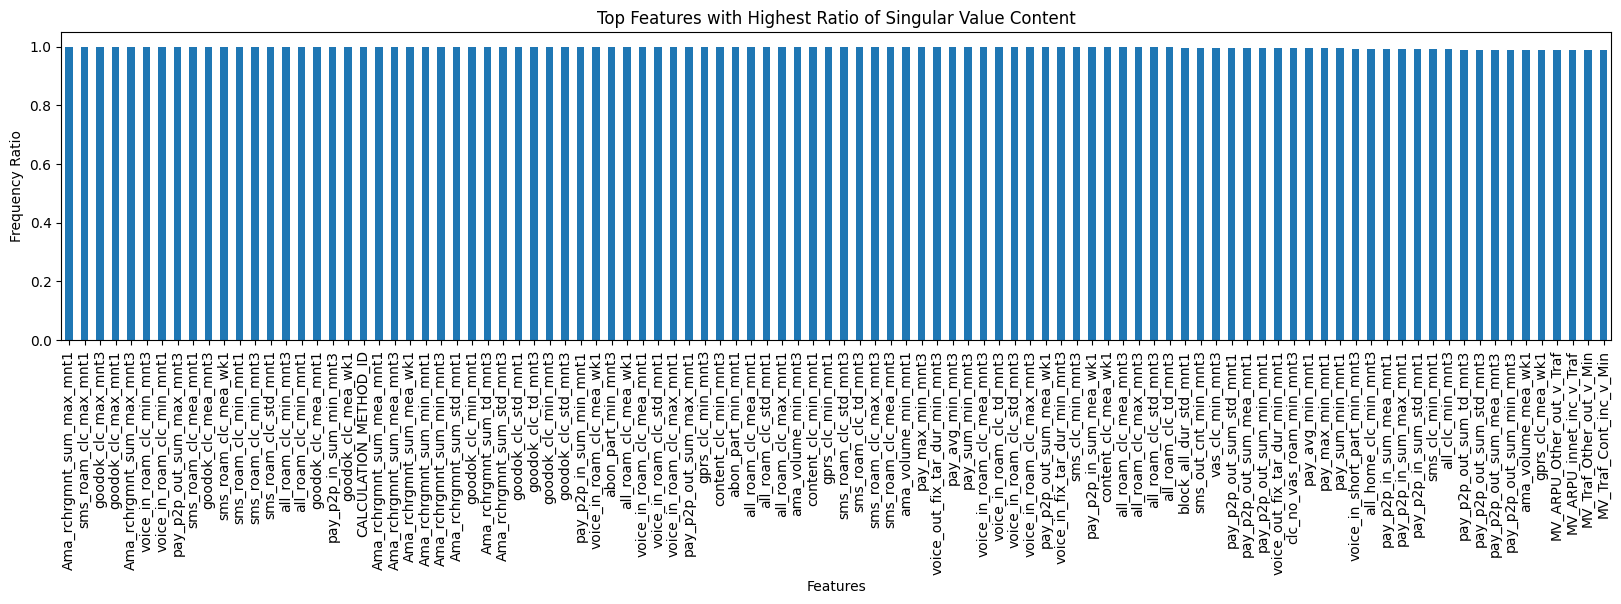

In [29]:
high_single_ratio = get_feature_with_high_singular_value_content(df_train_dpi_df_clean, threshold=0.9, plot=True)

In [32]:
# with  open(r'Data/features_high_single_ratio.json', 'w') as f:
#     json.dump({'high_single_ratio':  high_single_ratio.index.to_list()}, f)


In [37]:
high_single_ratio = features_single['high_single_ratio']

In [38]:
from scipy.stats import shapiro
# Function to perform the Shapiro-Wilk test
def is_normal_distribution(data, p_value_threshold=0.05):
    stat, p_value = shapiro(data)
    return p_value > p_value_threshold


In [ ]:
normal_columns = [col for col in df.columns if is_normal_distribution(df[col])]